##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [2]:
!pip install -U -q tensorflow==2.16.1  tensorflow_datasets

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Speech Commands dataset

This is the [dataset](https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/data_preview/index.html) that you will be working on. This dataset consists of 65,000 WAV Files and the audio clips were originally collected by Google, and recorded by volunteers in uncontrolled locations around the world.

In [5]:
DATASET_PATH = '/kaggle/input/tvd-2024-reconocimiento-de-comandos-de-voz/train/train/audio'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in 31 folders corresponding to each speech command. 

- 20 core words: `yes`, `no`, `up`, `down`, `left`,`right`, `on`, `off`, `stop`, `go`, `zero`, `one`,`two`, `three`, `four`, `five`,`six`, `seven`, `eight`, `nine`,   

- 10 auxiliary words: `bed`, `bird`, `cat`, `dog`, `happy`, `house`, `marvin`, `sheila`, `tree` and `wow`
  
- And background noise: `doing_the_dishes`, `dude_miaowing`, `exercise_bike`, `pink_noise`, `running_tap`, and `white_noise`.

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['no' 'two' 'four' 'five' 'nine' 'right' '_background_noise_' 'off' 'yes'
 'six' 'dog' 'left' 'bird' 'wow' 'zero' 'eight' 'bed' 'go' 'house' 'tree'
 'seven' 'on' 'three' 'one' 'down' 'stop' 'up' 'happy' 'marvin' 'cat'
 'sheila']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [12]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

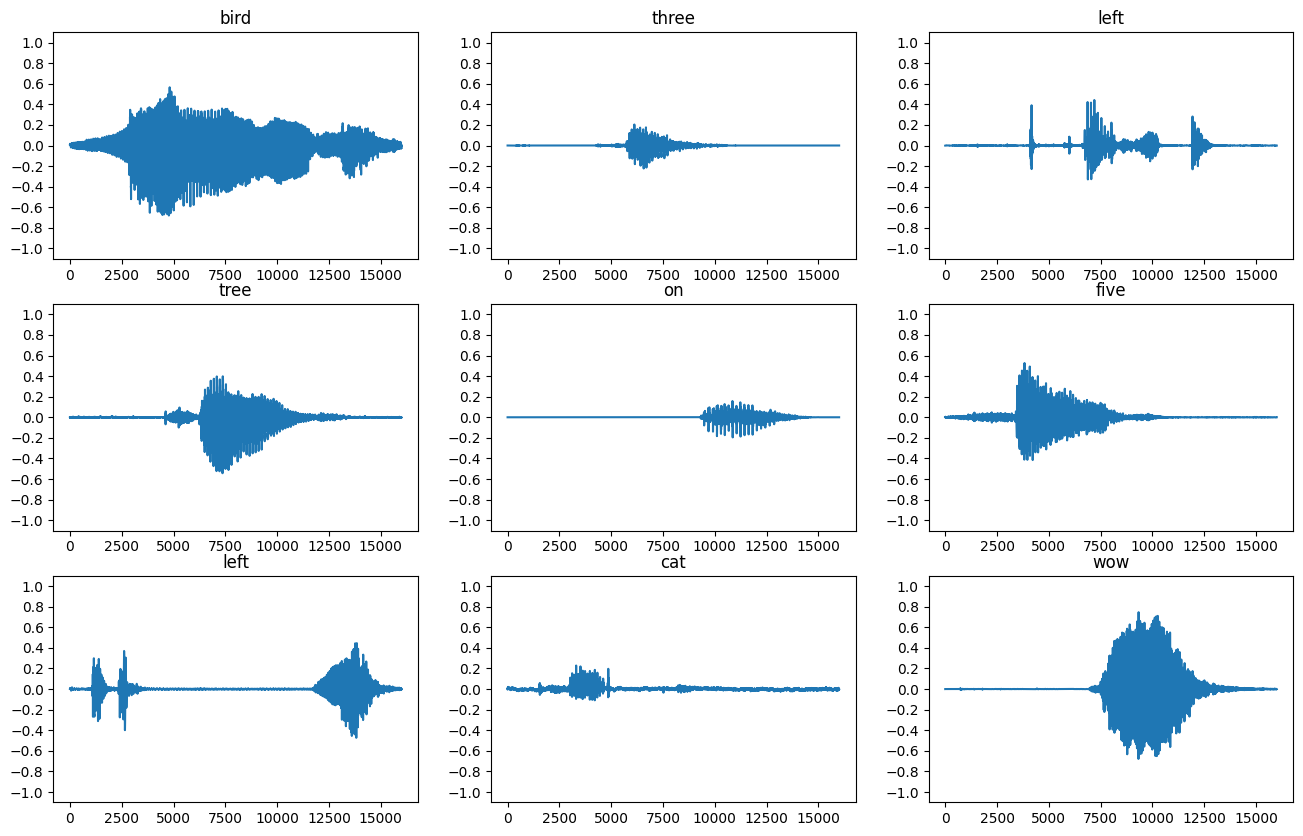

In [13]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [14]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


def get_mel_spectrogram(waveform, num_mel_bins=128):
    # Compute the STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectrogram = tf.abs(spectrogram)

    num_spectrogram_bins = spectrogram.shape[-1]

    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=16000,
        lower_edge_hertz=80.0, 
        upper_edge_hertz=8000.0)

    mel_spectrogram = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
    mel_spectrogram = tf.math.log1p(mel_spectrogram)

    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    
    return mel_spectrogram

def get_mfcc(waveform, num_mel_bins=128, num_mfccs=13):
    log_mel_spectrogram = get_mel_spectrogram(waveform, num_mel_bins)
    
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(tf.squeeze(log_mel_spectrogram, axis=-1))

    mfccs = mfccs[..., :num_mfccs]  # Select the desired number of MFCCs
    mfccs = mfccs[..., tf.newaxis]
    return mfccs

def get_power_spectrogram(waveform):
    # Compute the STFT
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Compute the power spectrogram (squared magnitude)
    power_spectrogram = tf.square(tf.abs(spectrogram))
    power_spectrogram = power_spectrogram[..., tf.newaxis]
    return power_spectrogram



Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [15]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

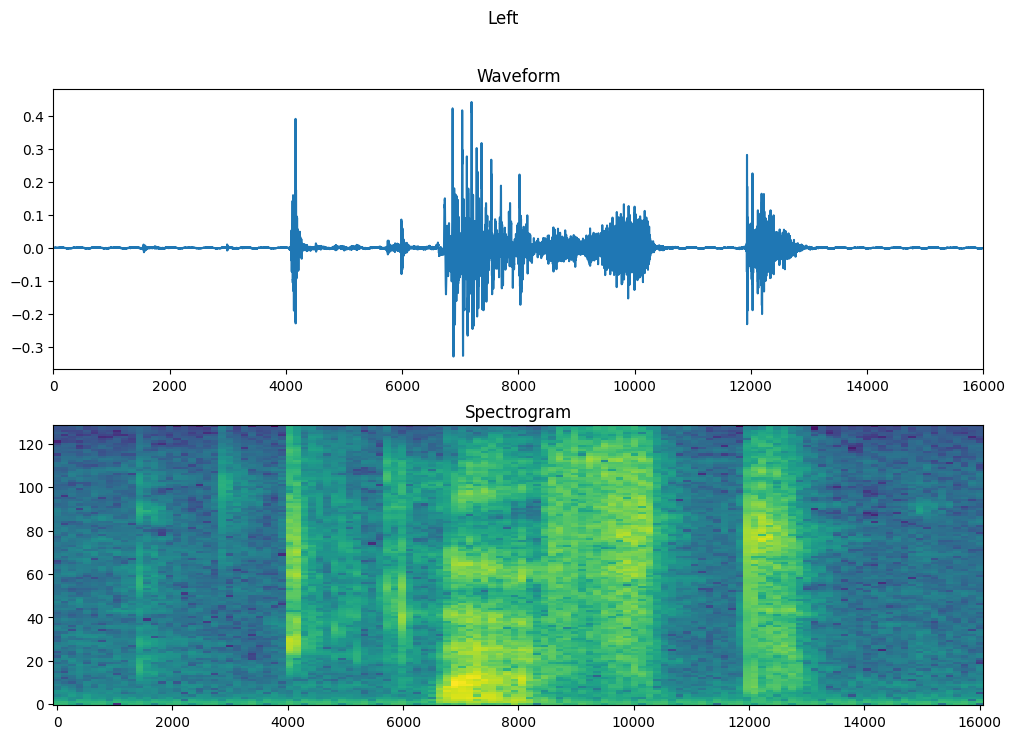

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [18]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


def make_mel_ds(ds, bins=128):
  return ds.map(
      map_func=lambda audio,label: (get_mel_spectrogram(audio, bins), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def make_mfcc_ds(ds, bins=128, mfcss=13):
  return ds.map(
      map_func=lambda audio,label: (get_mfcc(audio, bins, mfcss), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def make_power_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_power_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

    

In [19]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [20]:
spectrogram_datasets = {
    'spectrogram': {
        'train': make_spec_ds(train_ds),
        'val': make_spec_ds(val_ds),
        'test': make_spec_ds(test_ds)
    },
    'mel_spectrogram_64': {
        'train': make_mel_ds(train_ds, bins=64),
        'val': make_mel_ds(val_ds, bins=64),
        'test': make_mel_ds(test_ds, bins=64)
    },
    'mel_spectrogram_128': {
        'train': make_mel_ds(train_ds, bins=128),
        'val': make_mel_ds(val_ds, bins=128),
        'test': make_mel_ds(test_ds, bins=128)
    },
    'mfcc_64': {
        'train': make_mfcc_ds(train_ds, mfcss=64),
        'val': make_mfcc_ds(val_ds, mfcss=64),
        'test': make_mfcc_ds(test_ds, mfcss=64)
    }
}

## Build and train the model

In [46]:
train_spectrogram_ds = spectrogram_datasets['mel_spectrogram_64']['train']
val_spectrogram_ds = spectrogram_datasets['mel_spectrogram_64']['val']
test_spectrogram_ds = spectrogram_datasets['mel_spectrogram_64']['test']



In [47]:
train_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [35]:
for example_spectrograms, example_spect_labels in train_ds.take(1):
    break
input_shape = example_spectrograms.shape[1:]

def build_model(input_shape, label_names, normalization_type, normalization_positions):
    num_labels = len(label_names)
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Resizing(32, 32))

    # --- Normalization at the start ---
    if 'start' in normalization_positions:
        if normalization_type == 'proposed':
            norm_layer = layers.Normalization()
            norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))
            model.add(norm_layer)
        elif normalization_type == 'layern':
            norm_layer = layers.Normalization()
            norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))
            model.add(norm_layer)
            normalization_type = 'layer'
        elif normalization_type == 'layer':
            model.add(layers.LayerNormalization())
        elif normalization_type == 'batch':
            model.add(layers.BatchNormalization())

    # --- Convolutional Layers ---
    conv_layers = [
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D()
    ]

    for i, layer in enumerate(conv_layers):
        model.add(layer)

        # --- Normalization between convolutional layers ---
        if 'between_conv' in normalization_positions and i % 2 == 0 and i < len(conv_layers) -1:  # Between each MaxPooling
          if normalization_type == 'layer':
              model.add(layers.LayerNormalization())
          elif normalization_type == 'batch':
              model.add(layers.BatchNormalization())
        
        # --- Normalization after convolutional layers but before dense ---
        if 'after_conv' in normalization_positions and i == len(conv_layers) -1:  # After the last MaxPooling
          if normalization_type == 'layer':
              model.add(layers.LayerNormalization())
          elif normalization_type == 'batch':
              model.add(layers.BatchNormalization())

    # --- Dense Layers ---
    model.add(layers.Flatten())
    dense_layers = [
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_labels)
    ]

    for i, layer in enumerate(dense_layers):
        # --- Normalization between dense layers ---
        if 'between_dense' in normalization_positions and i == 0:
            if normalization_type == 'layer':
                model.add(layers.LayerNormalization())
            elif normalization_type == 'batch':
                model.add(layers.BatchNormalization())

        # --- Normalization before the final dense layer ---
        if 'before_dense' in normalization_positions and i == 0:
            if normalization_type == 'layer':
                model.add(layers.LayerNormalization())
            elif normalization_type == 'batch':
                model.add(layers.BatchNormalization())
        
        model.add(layer)

    return model

Training with normalization: none at positions: []


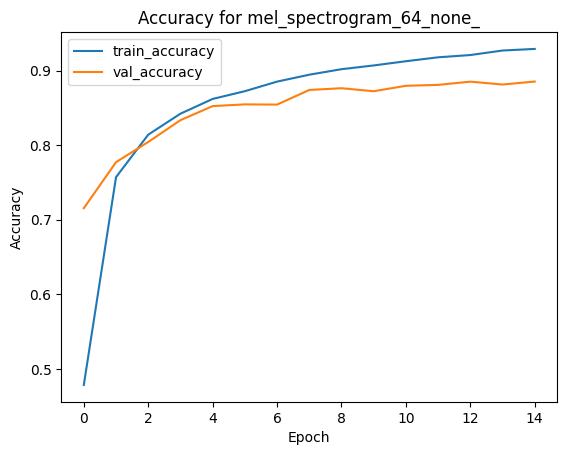

Training with normalization: layern at positions: ['start', 'between_conv', 'before_dense']


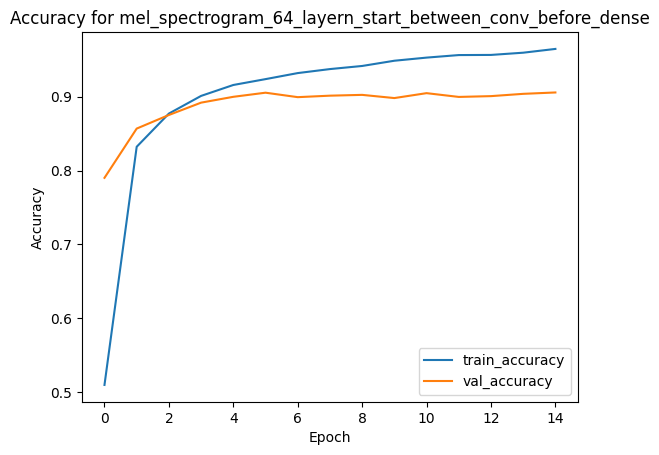


Training Results Summary:
- mel_spectrogram_64_none_:
  - Test Loss: 0.4461
  - Test Accuracy: 0.8854
- mel_spectrogram_64_layern_start_between_conv_before_dense:
  - Test Loss: 0.4015
  - Test Accuracy: 0.9056


In [48]:
def train_and_evaluate_model(model, train_ds, val_ds, model_name):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    EPOCHS = 15
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=0,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=0, patience=10),
    )

    # Save the model
    model.save(f'{model_name}.h5')
    
    # Evaluate the model
    loss, accuracy = model.evaluate(val_ds, verbose=0)

    return history, loss, accuracy

# Define the normalization configurations to test
normalization_configs = [
    {'type': 'none', 'positions': []},
    #{'type': 'proposed', 'positions': ['start']},
    #{'type': 'layer', 'positions': ['start']},
    #{'type': 'batch', 'positions': ['start']},
    #{'type': 'layern', 'positions': ['start', 'between_conv']},
    #{'type': 'batch', 'positions': ['start', 'between_conv']},
    #{'type': 'layer', 'positions': ['start', 'after_conv']},
    #{'type': 'batch', 'positions': ['start', 'after_conv']},
    #{'type': 'layer', 'positions': ['between_conv']},
    #{'type': 'batch', 'positions': ['between_conv']},
    #{'type': 'layer', 'positions': ['between_dense']},
    #{'type': 'batch', 'positions': ['between_dense']},
    #{'type': 'layer', 'positions': ['before_dense']},
    #{'type': 'batch', 'positions': ['before_dense']},
    #{'type': 'layer', 'positions': ['start', 'between_conv', 'before_dense']},
    #{'type': 'batch', 'positions': ['start', 'between_conv', 'before_dense']},
    #{'type': 'layern', 'positions': ['start', 'after_conv']},
    {'type': 'layern', 'positions': ['start', 'between_conv', 'before_dense']},
]

results = {}

for config in normalization_configs:
    norm_type = config['type']
    norm_positions = config['positions']
    model_name = f"mel_spectrogram_64_{norm_type}_{'_'.join(norm_positions)}"

    print(f"Training with normalization: {norm_type} at positions: {norm_positions}")

    # Build the model
    model = build_model(input_shape, label_names, norm_type, norm_positions)

    # Train and evaluate the model
    history, loss, accuracy = train_and_evaluate_model(model, train_ds, val_ds, model_name)

    # Store the results
    results[model_name] = {
        'history': history,
        'test_loss': loss,
        'test_accuracy': accuracy
    }

    # Plot accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'Accuracy for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{model_name}_accuracy.png')
    plt.show()

# Print a summary of results
print("\nTraining Results Summary:")
for name, result in results.items():
    print(f"- {name}:")
    print(f"  - Test Loss: {result['test_loss']:.4f}")
    print(f"  - Test Accuracy: {result['test_accuracy']:.4f}")

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Generate the submission file

The code below produces the `submission.csv` file, which you are required to submit for the competition. **Please do not make any changes in this cell**. 

In [ ]:
import pandas as pd

l = [[i,j] for i,j in zip(list(range(1,len(y_pred)+1)), y_pred.numpy().tolist())]

df = pd.DataFrame(l, columns=['ID','labels'])

df.to_csv('submission.csv', index=False)